In [1]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from libraries.clustering import apply_pca, plot_results, apply_tsne
from libraries import clustering
from sklearn.cluster import KMeans, OPTICS, DBSCAN
from scipy.spatial.distance import squareform
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.cluster import SpectralClustering
from pyclustering.cluster.optics import optics, ordering_analyser
from libraries.clustering import sil_vs_coh
from sklearn.metrics import pairwise_distances

DATASET_DIR = "dataset" + os.sep
RESULTS_DIR = "results" + os.sep

In [2]:
merged_df = pd.read_csv(DATASET_DIR + "merge_clean_v2-AD.csv", parse_dates=["date"])
cyclist_df = pd.read_csv(DATASET_DIR + "cyclist_clean_v2-AD.csv")
stages_df = pd.read_csv(DATASET_DIR + "stages_clean_v2-AD.csv", parse_dates=["date"])

In [3]:
cyclist_df.drop(columns=["name", "nationality", 'continent', "BMI"], inplace=True)
stages_df.drop(columns=["stage", "date", "race"], inplace=True)
merged_df.drop(columns=["date", "race", "stage", "nationality", 'profile', 'season', 'points', 'climb_total'], inplace=True)

merged_df.reset_index(drop=True, inplace=True)
cyclist_df.reset_index(drop=True, inplace=True)
stages_df.reset_index(drop=True, inplace=True)

merged_df = merged_df.dropna()
cyclist_df = cyclist_df.dropna()
stages_df = stages_df.dropna()

In [4]:
# transformation
cat_cyclist = []
stand_cyclist = ["height"]
minmax_cyclist = ["birth_year", 'avg_pos', 'num_races']
transformed_cyclists_data, preprocessor_cyclists = clustering.transform(
    cyclist_df,
    categorical_cols=cat_cyclist,
    standardize_cols=stand_cyclist,
    minmax_cols=minmax_cyclist,
)

cat_stage = []
stand_stage = []
minmax_stage = ["year", "length", "startlist_quality", 'avg_age_by_url', 'avg_delta_by_url']
transformed_stages_data, preprocessor_stages = clustering.transform(
    stages_df,
    categorical_cols=cat_stage,
    minmax_cols=minmax_stage,
    standardize_cols=stand_stage
)

# obtain df from the transformed data
transformed_cyclists_df = pd.DataFrame(transformed_cyclists_data)
transformed_stages_df = pd.DataFrame(transformed_stages_data)

# Add back the one-hot encoded columns
transformed_cyclists_df.columns = preprocessor_cyclists.get_feature_names_out(
    cyclist_df.columns
)
transformed_stages_df.columns = preprocessor_stages.get_feature_names_out(
    stages_df.columns
)

transformed_cyclists_df.reset_index(drop=True, inplace=True)
transformed_stages_df.reset_index(drop=True, inplace=True)

transformed_cyclists_df["_url"] = cyclist_df["_url"]
transformed_stages_df["_url"] = stages_df["_url"]

transformed_cyclists_df.drop(columns=["_url"], inplace=True)
transformed_stages_df.drop(columns=["_url"], inplace=True)

In [5]:
def filter_one_hot_columns(df):
    return df.loc[:, ~df.columns.str.startswith("cat__")]


real_cyclists_df = filter_one_hot_columns(transformed_cyclists_df)
real_stages_df = filter_one_hot_columns(transformed_stages_df)

real_cyclists_df.info()
real_stages_df.info()

cyclists = cyclist_df
stages = stages_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039 entries, 0 to 3038
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   standardize__height  3039 non-null   float64
 1   minmax__birth_year   3039 non-null   float64
 2   minmax__avg_pos      3039 non-null   float64
 3   minmax__num_races    3039 non-null   float64
dtypes: float64(4)
memory usage: 95.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   minmax__year               3021 non-null   float64
 1   minmax__length             3021 non-null   float64
 2   minmax__startlist_quality  3021 non-null   float64
 3   minmax__avg_age_by_url     3021 non-null   float64
 4   minmax__avg_delta_by_url   3021 non-null   float64
dtypes: float64(5)
memory usage: 118.1 KB


### Distributional approach

In [6]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


def dist_tune(df):
    aic_values = []
    bic_values = []
    k_range = range(1, 50)  # Testa valori di k da 1 a 10

    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=1804)
        gmm.fit(df.values)
        aic_values.append(gmm.aic(df.values))
        bic_values.append(gmm.bic(df.values))

    # Grafico dei valori AIC e BIC
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, aic_values, label='AIC', marker='o')
    plt.plot(k_range, bic_values, label='BIC', marker='o')
    plt.xlabel('Numero di Componenti (k)')
    plt.ylabel('AIC/BIC')
    plt.title('Selezione del numero ottimale di componenti')
    plt.legend()
    plt.show()

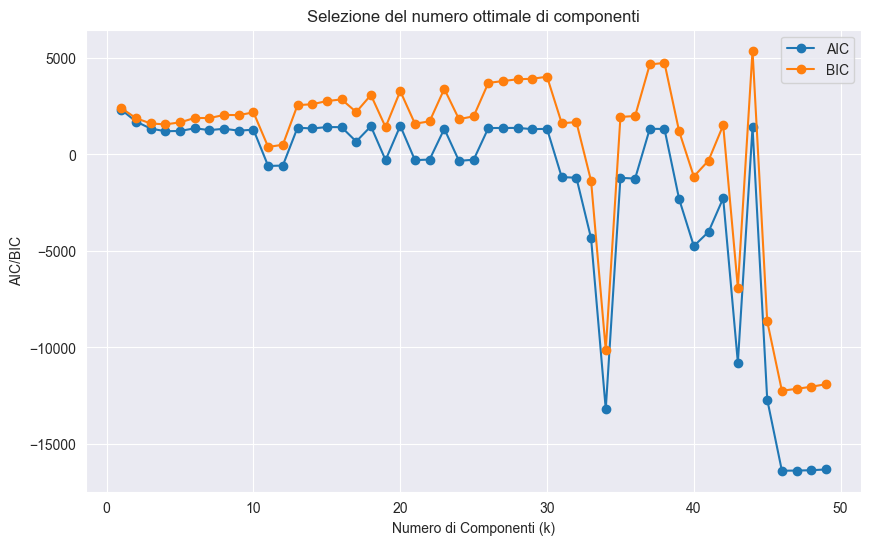

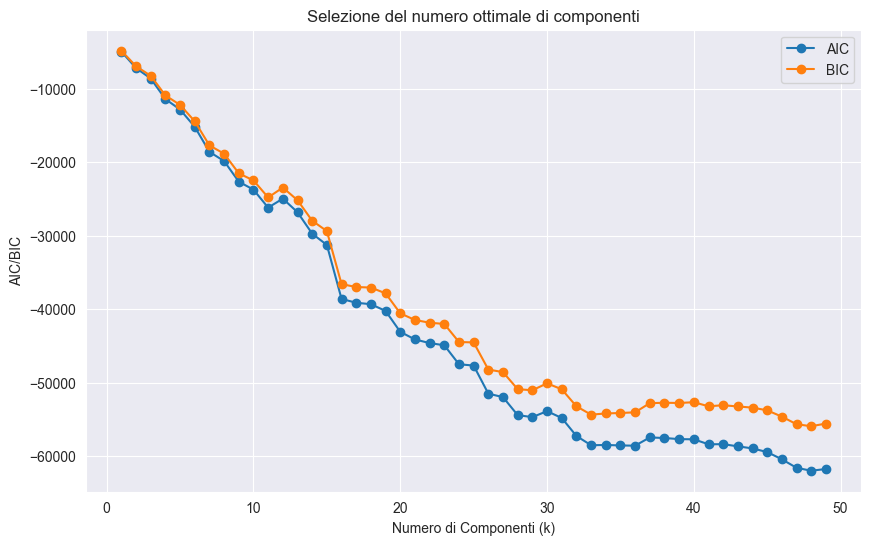

In [7]:
dist_tune(real_cyclists_df)
dist_tune(real_stages_df)

In [8]:
def dist_plot(df, res_df, k):
    algorithm = GaussianMixture(n_components=k)
    algorithm.fit(df.values)
    
    outlier_degrees_per_normal = algorithm.predict_proba(df.values)
    outlier_degrees = outlier_degrees_per_normal.max(axis=1)
    
    res_df.loc[:, "density_degree"] = outlier_degrees
    sorted_outlier_degrees = sorted(outlier_degrees)
    outlier_degrees_cdf = np.cumsum(sorted_outlier_degrees)
    
    sns.lineplot(
        x=range(df.shape[0]),
        y=sorted_outlier_degrees
    )
    plt.show()

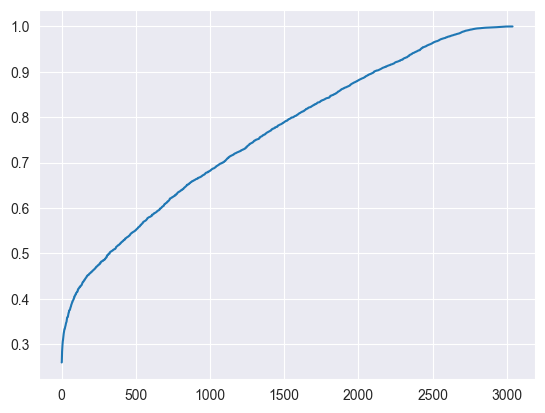

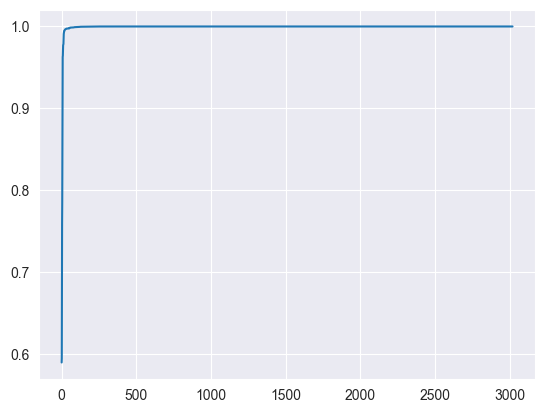

In [9]:
dist_plot(real_cyclists_df, cyclists, pow(2, real_cyclists_df.shape[1]))
dist_plot(real_stages_df, stages, pow(2, real_stages_df.shape[1]))

### Connectivity approach

In [10]:
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor

def conn_tune(df):
    k_values = range(2, 50, 2)
    silhouette_scores = []

    for k in k_values:
        lof = LocalOutlierFactor(n_neighbors=k)
        labels = lof.fit_predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)
    
    best_k = k_values[np.argmax(silhouette_scores)]
    
    sns.lineplot(
        x=range(2,50,2),
        y=silhouette_scores
    )
    print(f"Best k based on silhouette: {best_k}")
    plt.show()
    
    k_values = range(5, 50, 10)
    for k in k_values:
        lof = LocalOutlierFactor(n_neighbors=k)
        lof.fit(df)
        scores = -lof.negative_outlier_factor_
        plt.plot(sorted(scores), label=f"k={k}")
    
    plt.xlabel("Instances (sorted)")
    plt.ylabel("LOF scores")
    plt.legend()
    plt.title("Distribuzione dei punteggi LOF per diversi valori di k")
    plt.show()

Best k based on silhouette: 20


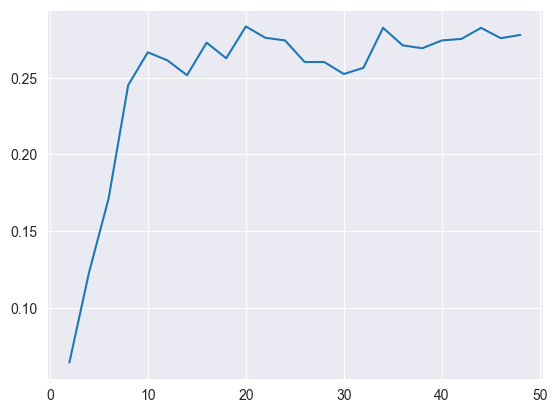

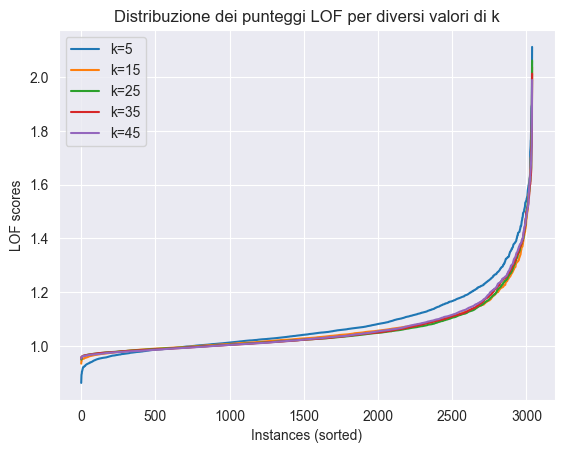

Best k based on silhouette: 38


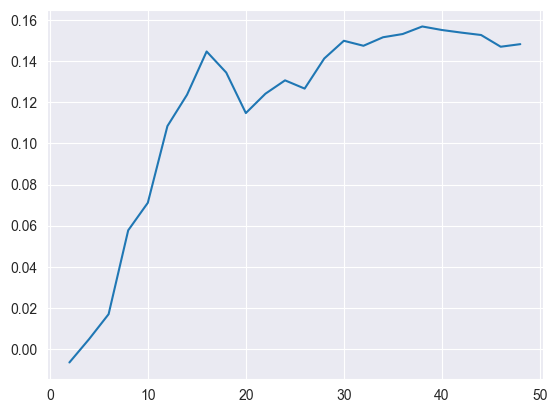

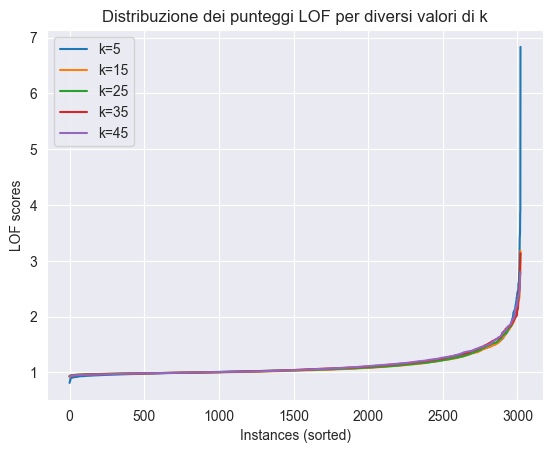

In [11]:
conn_tune(real_cyclists_df)
conn_tune(real_stages_df)

In [12]:
from scipy.spatial.distance import pdist
from sklearn.neighbors import LocalOutlierFactor

def conn_plot(df, res_df, k):
    k=int(k)
    algorithm = LocalOutlierFactor(n_neighbors=k)
    algorithm.fit(df)
    
    # negated outlier scores: the higher, the more of an outlier
    outlier_degrees = - algorithm.negative_outlier_factor_
    
    sorted_outlier_degrees = sorted(outlier_degrees)
    
    # to achieve comparable degrees among different algorithms,
    # we normalize distance-based scores by the maximum possible distance
    distances = squareform(pdist(df.values))
    maximum_possible_radius = distances.max()
    normalization_factor = maximum_possible_radius / k
    normalized_sorted_outlier_degrees = sorted_outlier_degrees / normalization_factor
    
    res_df.loc[:, "lof_degree_normalized"] = outlier_degrees / normalization_factor
    
    print(normalized_sorted_outlier_degrees)
    sns.lineplot(
        x=range(df.shape[0]),
        y=sorted_outlier_degrees
    )
    plt.show()

[1.72799115 1.74490012 1.75003311 ... 3.41850246 3.54823783 3.84216644]


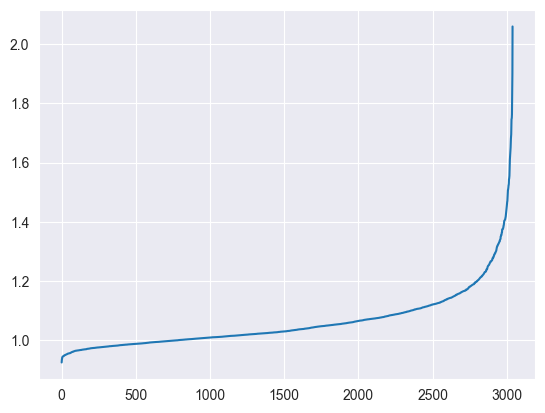

[ 6.07857452  6.12197137  6.13471853 ... 21.98196368 24.34357342
 24.50983623]


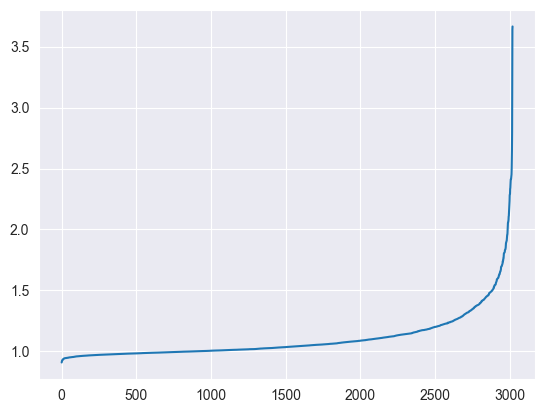

In [13]:
conn_plot(real_cyclists_df, cyclists, np.log2(real_cyclists_df.shape[0]))
conn_plot(real_stages_df, stages, np.log2(real_stages_df.shape[0]))

### SVM

In [14]:
from sklearn.svm import OneClassSVM


def svm_plot(df, res_df, kernel='rbf'):
    df = df.copy()
    
    algorithm = OneClassSVM(kernel=kernel)
    algorithm.fit(df)
    
    # this implementation provides two different scores:
    #   outlier classification in {+1, -1}
    #   outlier scores in R: distance from hyperplane
    outlier_classification_scores = algorithm.predict(df)
    outlier_distance_scores = algorithm.score_samples(df)

    sorted_outlier_degrees = sorted(outlier_distance_scores)
    
    # to achieve comparable degrees among different algorithms, we normalize distance-based scores by the maximum possible distance
    normalization_factor = sorted_outlier_degrees[-1]
    normalized_sorted_outlier_degrees = sorted_outlier_degrees / normalization_factor
    
    res_df.loc[:, "oneclass_svm_degree_normalized"] = outlier_distance_scores / normalization_factor
    res_df.loc[:, "oneclass_svm_degree_binary"] = 1 - (outlier_classification_scores  + 1) / 2  # map to {0, 1}
    
    sns.lineplot(
        x=range(df.shape[0]),
        y=sorted_outlier_degrees
    )    
    plt.figure(figsize=(6,6))
    plt.show()

Cyclists:


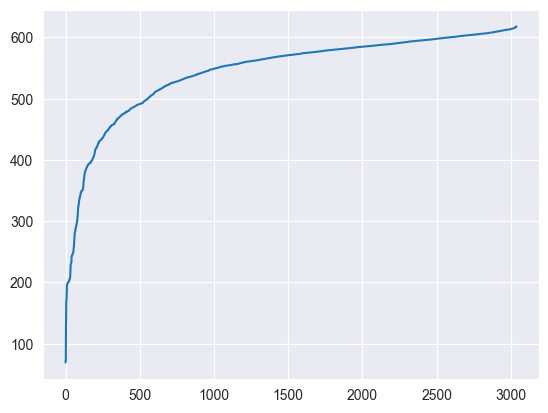

<Figure size 600x600 with 0 Axes>

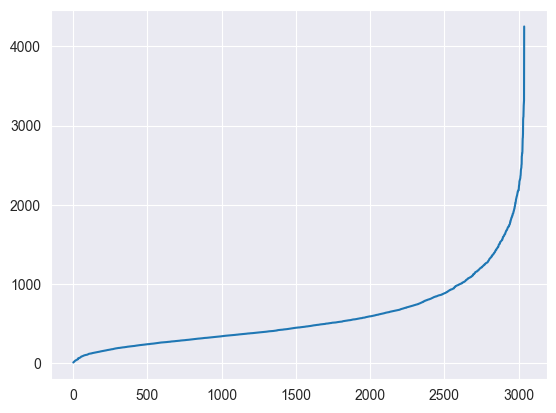

<Figure size 600x600 with 0 Axes>

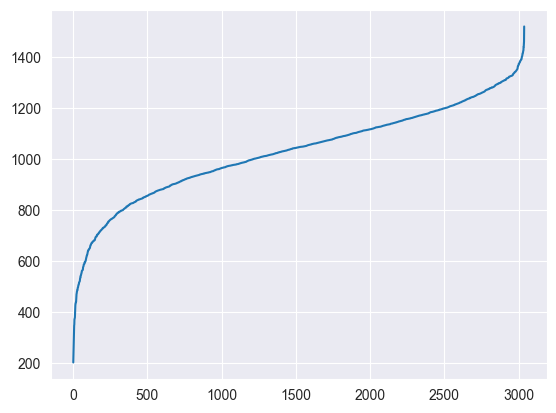

<Figure size 600x600 with 0 Axes>

Stages:


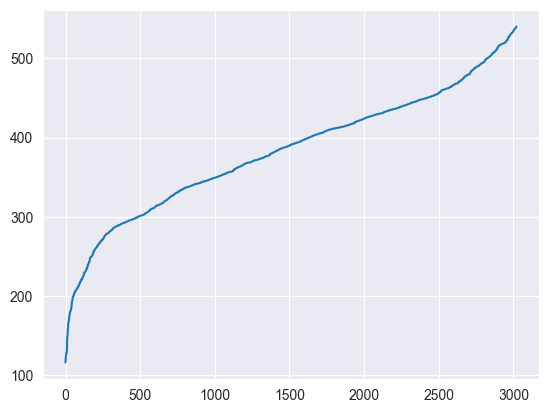

<Figure size 600x600 with 0 Axes>

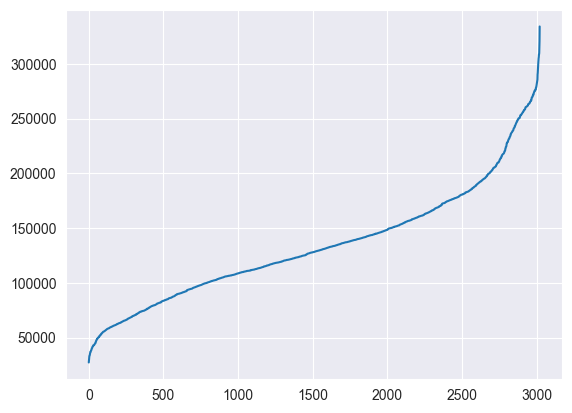

<Figure size 600x600 with 0 Axes>

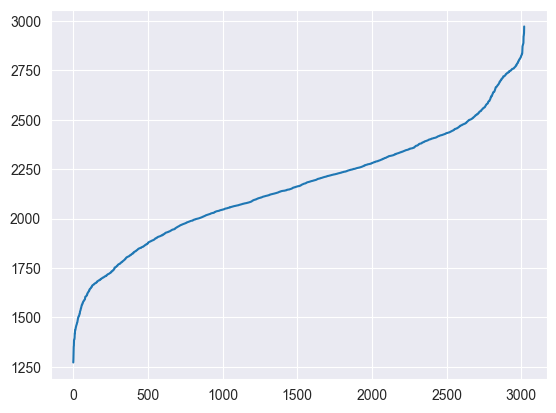

<Figure size 600x600 with 0 Axes>

In [15]:
print("Cyclists:")
svm_plot(real_cyclists_df, cyclists, 'rbf')
svm_plot(real_cyclists_df, pd.DataFrame(), 'poly')
svm_plot(real_cyclists_df, pd.DataFrame(), 'linear')
print("Stages:")
svm_plot(real_stages_df, stages, 'rbf')
svm_plot(real_stages_df, pd.DataFrame(), 'poly')
svm_plot(real_stages_df, pd.DataFrame(), 'linear')

### Isolation forests

In [16]:
from sklearn.ensemble import IsolationForest


def iso_plot(df, res_df):
    max_features = df.shape[1]
    algorithm = IsolationForest(max_features=max_features, random_state=1804)
    algorithm.fit(df)
    # the lower, more outliers
    outlier_degrees = algorithm.decision_function(df) + 0.5
    outlier_scores = 1 - (algorithm.predict(df) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)
    
    res_df.loc[:, "isolation_forest_degree"] = outlier_degrees
    res_df.loc[:, "isolation_forest_scores"] = outlier_scores
    
    sorted_outlier_degrees = sorted(outlier_degrees)
    
    sns.lineplot(
        x=range(df.shape[0]),
        y=sorted_outlier_degrees
    )

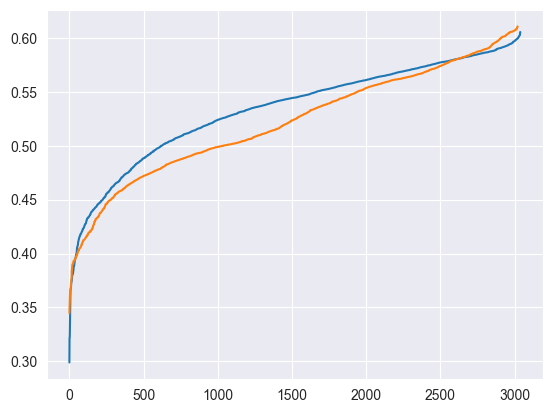

In [17]:
iso_plot(real_cyclists_df, cyclists)
iso_plot(real_stages_df, stages)

### Summary

In [18]:
print(cyclist_df)
print(stages)

                       _url  birth_year  height     avg_pos  num_races  \
0            johann-van-zyl        1991   190.0   70.818182         11   
1             robert-hunter        1977   178.0  117.959707        273   
2        anass-ait-el-abdia        1993   180.0   60.691489        564   
3             negasi-abreha        2000   186.0  103.792952        227   
4                  ryan-cox        1979   177.0   44.640091        439   
...                     ...         ...     ...         ...        ...   
3034          jhojan-garcia        1998   168.0   98.836000        250   
3035      alvaro-jose-hodeg        1996   186.0   44.541833        753   
3036   aldemar-reyes-ortega        1995   170.0   70.159827        463   
3037  eric-antonio-fagundez        1998   180.0   95.022890        699   
3038      jackson-rodriguez        1985   170.0   96.025346        434   

      density_degree  lof_degree_normalized  oneclass_svm_degree_normalized  \
0           0.997321            

In [19]:
def out_remove(df):
    threshold1 = np.percentile(df["lof_degree_normalized"], 10)
    threshold2 = np.percentile(df["density_degree"], 10)
    rows_to_drop = []

    # Loop through each row in the dataframe
    for idx, point in df.iterrows():
        c = 0  # Counter for the number of outlier conditions met
        
        # Checking different outlier conditions:
        if point['isolation_forest_scores']:  # If IsolationForest score indicates outlier
            c += 1
        if point['oneclass_svm_degree_binary']:  # If OneClassSVM degree is 1 (outlier)
            c += 1
        if point["lof_degree_normalized"] < threshold1:  # If LOF degree is below threshold
            c += 1
        if point["density_degree"] < threshold2:  # If GMM density degree is below threshold
            c += 1
        
        # If more than 2 outlier conditions are met, mark the point for removal
        if c >= 3:
            rows_to_drop.append(idx)
    
    # Drop the rows that are marked as outliers
    df.drop(rows_to_drop, axis=0, inplace=True)

In [20]:
print(cyclists.shape)
print(stages.shape)

out_remove(cyclists)
out_remove(stages)

print(cyclists.shape)
print(stages.shape)

(3039, 11)
(3021, 17)
(2999, 11)
(2839, 17)


In [21]:
cyclists.info()
stages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2999 entries, 0 to 3038
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _url                            2999 non-null   object 
 1   birth_year                      2999 non-null   int64  
 2   height                          2999 non-null   float64
 3   avg_pos                         2999 non-null   float64
 4   num_races                       2999 non-null   int64  
 5   density_degree                  2999 non-null   float64
 6   lof_degree_normalized           2999 non-null   float64
 7   oneclass_svm_degree_normalized  2999 non-null   float64
 8   oneclass_svm_degree_binary      2999 non-null   float64
 9   isolation_forest_degree         2999 non-null   float64
 10  isolation_forest_scores         2999 non-null   float64
dtypes: float64(8), int64(2), object(1)
memory usage: 281.2+ KB
<class 'pandas.core.frame.DataFrame'>
Ind

In [22]:
columns_to_drop = cyclists.columns[5:11]  # Adjust the range as needed
cyclists.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = stages.columns[11:17]  # Adjust the range as needed
stages.drop(columns_to_drop, axis=1, inplace=True)

In [23]:
cyclists.info()
stages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2999 entries, 0 to 3038
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   _url        2999 non-null   object 
 1   birth_year  2999 non-null   int64  
 2   height      2999 non-null   float64
 3   avg_pos     2999 non-null   float64
 4   num_races   2999 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 140.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2839 entries, 0 to 3020
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _url               2839 non-null   object 
 1   points             2839 non-null   int64  
 2   length             2839 non-null   int64  
 3   climb_total        2839 non-null   int64  
 4   profile            2839 non-null   int64  
 5   startlist_quality  2839 non-null   int64  
 6   year               2839 non-null   int64  
 7   season   

In [24]:
cyclists.to_csv('dataset/cyclist_clean_v3.csv')
stages.to_csv('dataset/stages-clean_v3.csv')